# Preprocesamiento de Datos - WhoWouldWin Dataset

Este notebook prepara el dataset de debates hipotéticos para entrenamiento de un modelo seq2seq.

**Objetivo**: Partir desde `data/whowouldwin_dataset.json` y crear datasets listos para entrenamiento

In [71]:
# Importación de librerías necesarias
import json
import pandas as pd
import numpy as np
import re
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Configuración de reproducibilidad
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print("Librerías importadas correctamente")

Librerías importadas correctamente


## 1. Carga del Dataset

In [72]:
# Cargar el dataset JSON
def load_dataset(file_path):
    """Carga el dataset desde archivo JSON"""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print(f"Dataset cargado exitosamente: {len(data)} ejemplos")
        return data
    except FileNotFoundError:
        print(f"Error: No se encontró el archivo {file_path}")
        return None
    except Exception as e:
        print(f"Error al cargar el dataset: {e}")
        return None

# Cargar datos
raw_data = load_dataset('data/whowouldwin_dataset.json')

# Convertir a DataFrame
df = pd.DataFrame(raw_data)
print(f"\nForma del DataFrame: {df.shape}")
print(f"Columnas: {df.columns.tolist()}")
df.head()

Dataset cargado exitosamente: 9475 ejemplos

Forma del DataFrame: (9475, 2)
Columnas: ['input', 'output']


,input,output
0,The penguins of magadascar have 72 hours and t...,They have the entire military budget just to c...
1,The penguins of magadascar have 72 hours and t...,Given the fact that we can have Kowalski on an...
2,The penguins of magadascar have 72 hours and t...,Ah good twist. If they had to kill him and thi...
3,The penguins of magadascar have 72 hours and t...,“They also cant be detected as Osama Bin Laden...
4,The penguins of magadascar have 72 hours and t...,This would make a great writing prompt. Permis...


## 2. Análisis Exploratorio Básico

In [73]:
# Análisis de longitudes de texto
df['input_length'] = df['input'].apply(len)
df['output_length'] = df['output'].apply(len)
df['input_words'] = df['input'].apply(lambda x: len(x.split()))
df['output_words'] = df['output'].apply(lambda x: len(x.split()))

# Estadísticas descriptivas
print("Estadísticas de longitud de caracteres:")
print(df[['input_length', 'output_length']].describe())
print("\nEstadísticas de longitud en palabras:")
print(df[['input_words', 'output_words']].describe())

Estadísticas de longitud de caracteres:
       input_length  output_length
count   9475.000000    9475.000000
mean     714.357889     426.814881
std     1102.894663     610.209914
min       34.000000      31.000000
25%      307.000000     115.000000
50%      495.000000     233.000000
75%      809.000000     489.000000
max    27062.000000    9706.000000

Estadísticas de longitud en palabras:
       input_words  output_words
count  9475.000000   9475.000000
mean    125.915884     75.847810
std     189.253287    107.034913
min       7.000000      3.000000
25%      55.000000     21.000000
50%      87.000000     42.000000
75%     143.000000     88.000000
max    4595.000000   1683.000000


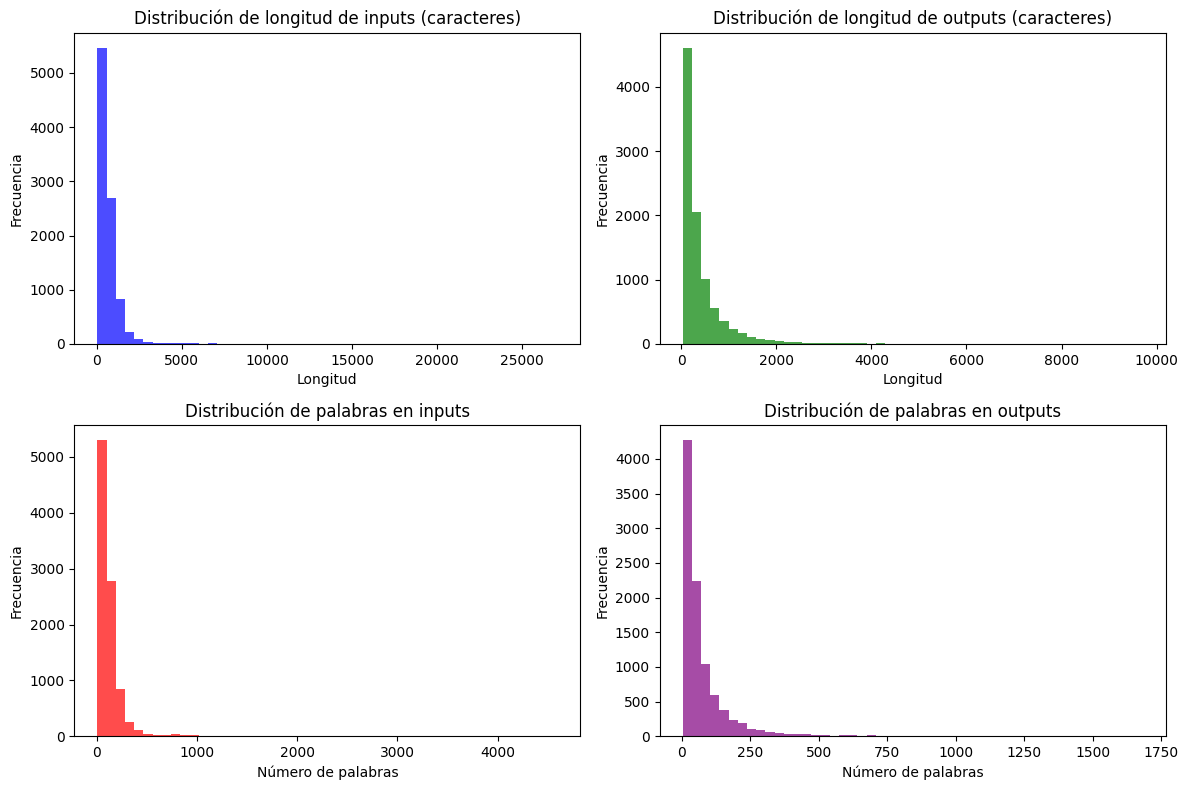

In [75]:
# Visualización de distribuciones
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Distribución de longitudes de input
axes[0, 0].hist(df['input_length'], bins=50, alpha=0.7, color='blue')
axes[0, 0].set_title('Distribución de longitud de inputs (caracteres)')
axes[0, 0].set_xlabel('Longitud')
axes[0, 0].set_ylabel('Frecuencia')

# Distribución de longitudes de output
axes[0, 1].hist(df['output_length'], bins=50, alpha=0.7, color='green')
axes[0, 1].set_title('Distribución de longitud de outputs (caracteres)')
axes[0, 1].set_xlabel('Longitud')
axes[0, 1].set_ylabel('Frecuencia')

# Distribución de palabras en input
axes[1, 0].hist(df['input_words'], bins=50, alpha=0.7, color='red')
axes[1, 0].set_title('Distribución de palabras en inputs')
axes[1, 0].set_xlabel('Número de palabras')
axes[1, 0].set_ylabel('Frecuencia')

# Distribución de palabras en output
axes[1, 1].hist(df['output_words'], bins=50, alpha=0.7, color='purple')
axes[1, 1].set_title('Distribución de palabras en outputs')
axes[1, 1].set_xlabel('Número de palabras')
axes[1, 1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

## 3. Limpieza de Texto

In [78]:
def clean_text(text):
    """
    Limpia y normaliza el texto:
    - Elimina caracteres especiales excesivos
    - Normaliza espacios
    - Mantiene puntuación básica
    """
    # Eliminar saltos de línea múltiples
    text = re.sub(r'\n+', ' ', text)
    
    # Eliminar espacios múltiples
    text = re.sub(r'\s+', ' ', text)
    
    # Eliminar caracteres de control
    text = re.sub(r'[\x00-\x1f\x7f-\x9f]', '', text)
    
    # Normalizar comillas
    text = text.replace('\u201c', '"').replace('\u201d', '"').replace('\u2018', "'").replace('\u2019', "'")
    
    # Eliminar espacios al inicio y final
    text = text.strip()
    
    return text

# Aplicar limpieza
print("Aplicando limpieza de texto...")
df['input_clean'] = df['input'].apply(clean_text)
df['output_clean'] = df['output'].apply(clean_text)

# Mostrar ejemplos de limpieza
print("\nEjemplo de limpieza:")
sample_idx = 0
print(f"Original: {df.iloc[sample_idx]['input'][:100]}...")
print(f"Limpio: {df.iloc[sample_idx]['input_clean'][:100]}...")

Aplicando limpieza de texto...

Ejemplo de limpieza:
Original: The penguins of magadascar have 72 hours and the US military budget to find bin laden They are sent ...
Limpio: The penguins of magadascar have 72 hours and the US military budget to find bin laden They are sent ...


## 4. Filtrado de Ejemplos por Longitud

In [79]:
# Calcular longitudes después de limpieza
df['input_clean_words'] = df['input_clean'].apply(lambda x: len(x.split()))
df['output_clean_words'] = df['output_clean'].apply(lambda x: len(x.split()))

# Definir límites para filtrado (optimizado para recursos limitados)
MIN_INPUT_WORDS = 1
MAX_INPUT_WORDS = 10000  # Reducido para memoria limitada
MIN_OUTPUT_WORDS = 1
MAX_OUTPUT_WORDS = 10000  # Reducido para memoria limitada

print(f"Datos antes del filtrado: {len(df)}")

# Filtrar por longitud
df_filtered = df[
    (df['input_clean_words'] >= MIN_INPUT_WORDS) & 
    (df['input_clean_words'] <= MAX_INPUT_WORDS) &
    (df['output_clean_words'] >= MIN_OUTPUT_WORDS) & 
    (df['output_clean_words'] <= MAX_OUTPUT_WORDS)
].copy()

print(f"Datos después del filtrado: {len(df_filtered)}")
print(f"Porcentaje retenido: {len(df_filtered)/len(df)*100:.2f}%")

Datos antes del filtrado: 9475
Datos después del filtrado: 9475
Porcentaje retenido: 100.00%


## 5. Preparación para T5 - Agregar Prefijos

In [80]:
# Agregar prefijo para tarea de generación argumentativa
def add_prefix(text):
    """Agrega prefijo para la tarea de argumentación"""
    return f"argumenta sobre: {text}"

# Aplicar prefijo
df_filtered['input_prefix'] = df_filtered['input_clean'].apply(add_prefix)

# Mostrar ejemplos
print("Ejemplos con prefijo:")
for i in range(3):
    print(f"\nEjemplo {i+1}:")
    print(f"Input: {df_filtered.iloc[i]['input_prefix'][:100]}...")
    print(f"Output: {df_filtered.iloc[i]['output_clean'][:100]}...")

Ejemplos con prefijo:

Ejemplo 1:
Input: argumenta sobre: The penguins of magadascar have 72 hours and the US military budget to find bin lad...
Output: They have the entire military budget just to capture Bin Laden? Okay. Wanted: Osama Bin Laden 850 bi...

Ejemplo 2:
Input: argumenta sobre: The penguins of magadascar have 72 hours and the US military budget to find bin lad...
Output: Given the fact that we can have Kowalski on analysis and Private on recon, this is a piece of cake. ...

Ejemplo 3:
Input: argumenta sobre: The penguins of magadascar have 72 hours and the US military budget to find bin lad...
Output: Ah good twist. If they had to kill him and this is an R rated version of the Penguins, they for sure...


## 6. División Train/Val/Test

In [81]:
# División 80/10/10
train_df, temp_df = train_test_split(
    df_filtered, 
    test_size=0.2, 
    random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5, 
    random_state=RANDOM_SEED
)

print(f"Train: {len(train_df)} ejemplos ({len(train_df)/len(df_filtered)*100:.1f}%)")
print(f"Val: {len(val_df)} ejemplos ({len(val_df)/len(df_filtered)*100:.1f}%)")
print(f"Test: {len(test_df)} ejemplos ({len(test_df)/len(df_filtered)*100:.1f}%)")

Train: 7580 ejemplos (80.0%)
Val: 947 ejemplos (10.0%)
Test: 948 ejemplos (10.0%)


## 7. Creación de Dataset Class para PyTorch

In [83]:
class WhoWouldWinDataset(Dataset):
    """Dataset personalizado para el problema de argumentación"""
    
    def __init__(self, dataframe, tokenizer, max_input_length=10000, max_output_length=10000):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.max_output_length = max_output_length
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        # Tokenizar input
        input_encoding = self.tokenizer(
            row['input_prefix'],
            max_length=self.max_input_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Tokenizar output (target)
        target_encoding = self.tokenizer(
            row['output_clean'],
            max_length=self.max_output_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Preparar labels (reemplazar padding con -100)
        labels = target_encoding['input_ids']
        labels[labels == self.tokenizer.pad_token_id] = -100
        
        return {
            'input_ids': input_encoding['input_ids'].squeeze(),
            'attention_mask': input_encoding['attention_mask'].squeeze(),
            'labels': labels.squeeze()
        }

## 8. Inicialización del Tokenizer y Creación de DataLoaders

In [85]:
# Inicializar tokenizer T5
print("Cargando tokenizer T5-small...")
tokenizer = AutoTokenizer.from_pretrained('t5-small')

# Parámetros de longitud (optimizados para recursos limitados)
MAX_INPUT_LENGTH = 10000  # Reducido de 512
MAX_OUTPUT_LENGTH = 10000  # Reducido de 256

# Crear datasets
train_dataset = WhoWouldWinDataset(train_df, tokenizer, MAX_INPUT_LENGTH, MAX_OUTPUT_LENGTH)
val_dataset = WhoWouldWinDataset(val_df, tokenizer, MAX_INPUT_LENGTH, MAX_OUTPUT_LENGTH)
test_dataset = WhoWouldWinDataset(test_df, tokenizer, MAX_INPUT_LENGTH, MAX_OUTPUT_LENGTH)

print(f"\nDatasets creados:")
print(f"Train: {len(train_dataset)} ejemplos")
print(f"Val: {len(val_dataset)} ejemplos")
print(f"Test: {len(test_dataset)} ejemplos")

Cargando tokenizer T5-small...

Datasets creados:
Train: 7580 ejemplos
Val: 947 ejemplos
Test: 948 ejemplos


In [86]:
# Crear DataLoaders (batch size pequeño para memoria limitada)
BATCH_SIZE = 4  # Muy pequeño para recursos limitados

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=0  # Evitar problemas de memoria
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=0
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=0
)

print(f"DataLoaders creados con batch_size={BATCH_SIZE}")
print(f"Batches en train: {len(train_loader)}")
print(f"Batches en val: {len(val_loader)}")
print(f"Batches en test: {len(test_loader)}")

DataLoaders creados con batch_size=4
Batches en train: 1895
Batches en val: 237
Batches en test: 237


## 9. Verificación de un Batch de Ejemplo

In [88]:
# Versión corta
sample_batch = next(iter(train_loader))

print("Estructura del batch:")
for key, value in sample_batch.items():
    print(f"{key}: shape {value.shape}")

# Decodificar ejemplos
sample_input = tokenizer.decode(sample_batch['input_ids'][0], skip_special_tokens=True)
# Filtrar -100 de las labels antes de decodificar
valid_labels = sample_batch['labels'][0][sample_batch['labels'][0] != -100]
sample_output = tokenizer.decode(valid_labels, skip_special_tokens=True)

print(f"\nInput: {sample_input[:100]}...")
print(f"Output: {sample_output[:100]}...")

Estructura del batch:
input_ids: shape torch.Size([4, 10000])
attention_mask: shape torch.Size([4, 10000])
labels: shape torch.Size([4, 10000])

Input: argumenta sobre: The Phantom Menace Palpatine vs. Revenge of the Sith Obi-Wan? Who wins in a combina...
Output: Palpatine killed Plageuis around the end of TPM, so he was still extremely strong. I also don't see ...


## 10. Guardado de Datasets Procesados

In [90]:
# Preparar DataFrames para guardar
columns_to_save = ['input_prefix', 'output_clean']

train_save = train_df[columns_to_save].copy()
val_save = val_df[columns_to_save].copy()
test_save = test_df[columns_to_save].copy()

# Renombrar columnas para claridad
train_save.columns = ['input', 'output']
val_save.columns = ['input', 'output']
test_save.columns = ['input', 'output']

# Guardar como CSV
train_save.to_csv('data/train_data.csv', index=False)
val_save.to_csv('data/val_data.csv', index=False)
test_save.to_csv('data/test_data.csv', index=False)

print("Datasets guardados:")
print("- data/train_data.csv")
print("- data/val_data.csv")
print("- data/test_data.csv")

Datasets guardados:
- data/train_data.csv
- data/val_data.csv
- data/test_data.csv


In [92]:
# Guardar también los objetos de dataset para fácil carga posterior
import pickle

dataset_config = {
    'tokenizer_name': 't5-small',
    'max_input_length': MAX_INPUT_LENGTH,
    'max_output_length': MAX_OUTPUT_LENGTH,
    'batch_size': BATCH_SIZE,
    'train_size': len(train_df),
    'val_size': len(val_df),
    'test_size': len(test_df)
}

with open('data/dataset_config.pkl', 'wb') as f:
    pickle.dump(dataset_config, f)

print("\nConfiguración del dataset guardada en data/dataset_config.pkl")
print(f"\nResumen final:")
for key, value in dataset_config.items():
    print(f"{key}: {value}")


Configuración del dataset guardada en data/dataset_config.pkl

Resumen final:
tokenizer_name: t5-small
max_input_length: 10000
max_output_length: 10000
batch_size: 4
train_size: 7580
val_size: 947
test_size: 948


## Resumen del Preprocesamiento

- ✅ Dataset cargado y convertido a DataFrame
- ✅ Análisis exploratorio completado
- ✅ Texto limpiado y normalizado
- ✅ Ejemplos filtrados por longitud para optimizar recursos
- ✅ División train/val/test (80/10/10)
- ✅ Dataset class personalizada creada
- ✅ Tokenización con T5
- ✅ DataLoaders optimizados creados
- ✅ Datasets guardados en formato CSV

**Siguiente paso**: Proceder con el entrenamiento del modelo en `model_training.ipynb`